# Unmyelinated C-fiber model - convergence study

## Objectives
- Implement unmyelinated fiber model working with intracellular and extracellular current stimulation, as well as acoustic stimulation.
- Simulate the model upon intracellular current injection at the central node, for increasing spatial resolution (i.e. decreasing node length)
- Quantify the model convergence via 3 output metrics: stimulation threshold, conduction velocity and spike amplitude
- Evaluate the required spatial resolution (node length) to achieve a reliable convergence within a 5 % error margin (relative to maximal resolution).

## Rationale

An single-cable unmyelinated fiber model is constructed by simply setting internodal length to zero, and specifying fixing fiber length at instantiation. 
The number of nodes is derived from the required spatial resolution (i.e. the maximal node length), also specified at instantiation. 

Spatial resolution is expected to greatly affect simulations, since:
- low resolution could yield inaccurate simulation results (conduction velocity, spike amplitude), and eventually lead to action potential propagation failure 
- high resolution could induce a dramatic increase in computation time 

Therefore, we wish to find a trade-off in spatial resolution, with a node length small enough to produce accurate results, yet large enough to keep computation times reasonable. 

### Imports

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np

from PySONIC.core import PulsedProtocol
from PySONIC.neurons import getPointNeuron
from PySONIC.utils import logger, si_format
from ExSONIC.core import IintraFiber, IntracellularCurrent, unmyelinatedFiber, unmyelinatedFiberConvergence
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, plotConvergenceResults

logger.setLevel(logging.INFO)

## Default parameters

We use identical parameters as in the Sundt 2015 paper (0.8 um diameter, 5 mm long peripheral axon with fast Sodium, delayed-rectifier Potassium and leakage currents)

In [2]:
# Unmyelinated fiber model parameters
pneuron = getPointNeuron('sundt')          # C-fiber membrane equations
fiberD = 0.8e-6                            # peripheral axon diameter, from Sundt 2015 (m)
rs = 1e2                                   # axoplasm resistivity, from Sundt 2015 (Ohm.cm)
fiberL = 5e-3                              # axon length (m)
maxNodeL_range = np.logspace(-5, -3, 100)  # maximum node length range: from 10 um to 1 mm

# Stimulation parameters
tstim = 10e-6     # s
toffset = 15e-3  # s
pp = PulsedProtocol(tstim, toffset)

# Relative error threshold for convergence study
rel_eps_thr = 0.05

### Run convergence

 09/12/2019 12:08:54: running maxNodeL parameter sweep (10.00 um - 1.00 mm)
 09/12/2019 12:08:54: parameter sweep successfully completed
 09/12/2019 12:08:54: loading results from log file
 09/12/2019 12:08:54: Relative error threshold = 5.0 %
 09/12/2019 12:08:54: Max nodeL (m) = 2.65e-05


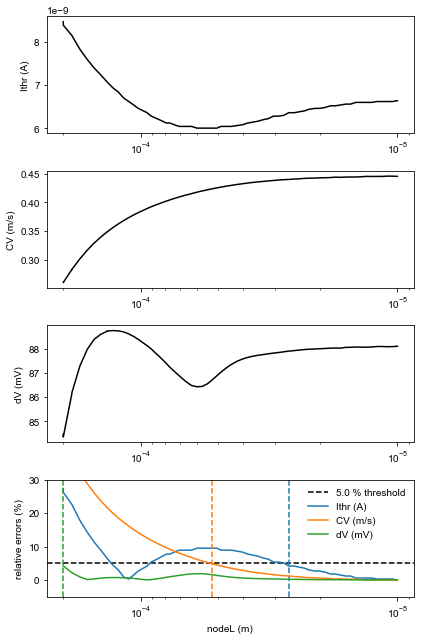

In [3]:
df = unmyelinatedFiberConvergence(pneuron, fiberD, rs, fiberL, maxNodeL_range, pp, outdir='.')
_, inkey, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr)

As we can see, as the node length is decreased, the 3 output metrics converge to specific asymptotic values:
- excitation threshold: 6.7 nA
- conduction velocity: 0.44 m/s
- spike amplitude: 88 mV

Setting a maximum relative error of 5%, we deduce that **a node length of around 25 um is required to achieve a reasonable accuracy**. Such a node length does not heavily compromise the computation time (model construction and simulation within a few seconds).

That number is in accordance (same order of magnitude) with the discretization strategy used in Sundt 2015 (100 segments for a 5 mm long peripheral axon, i.e. 50 um length per segment)

## Exploring other diameters

In order to make sure that our discretization threshold is robust, let us re-run the convergence study for other fiber diameters within the physiologically realistic range:

### 0.2 um diameter

 09/12/2019 12:08:56: running maxNodeL parameter sweep (10.00 um - 1.00 mm)
 09/12/2019 12:08:56: parameter sweep successfully completed
 09/12/2019 12:08:56: loading results from log file
 09/12/2019 12:08:56: Relative error threshold = 5.0 %
 09/12/2019 12:08:56: Max nodeL (m) = 1.74e-05


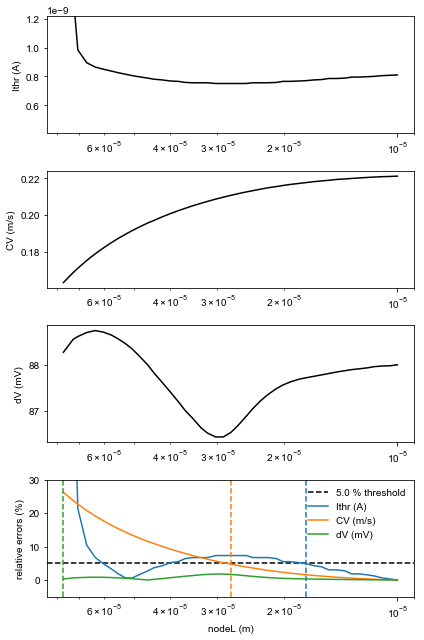

In [4]:
fiberD = 0.2e-6  # (m)
df = unmyelinatedFiberConvergence(pneuron, fiberD, rs, fiberL, maxNodeL_range, pp, outdir='.')
_, inkey, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr)

### 1.5 um diameter

 09/12/2019 12:08:57: running maxNodeL parameter sweep (10.00 um - 1.00 mm)
 09/12/2019 12:08:57: parameter sweep successfully completed
 09/12/2019 12:08:57: loading results from log file
 09/12/2019 12:08:57: Relative error threshold = 5.0 %
 09/12/2019 12:08:57: Max nodeL (m) = 3.31e-05


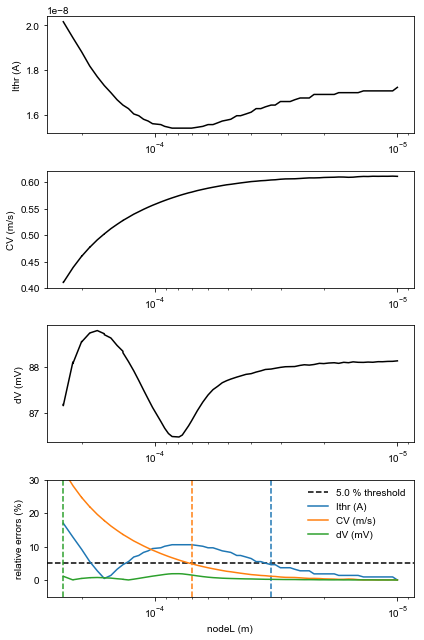

In [5]:
fiberD = 1.5e-6  # (m)
df = unmyelinatedFiberConvergence(pneuron, fiberD, rs, fiberL, maxNodeL_range, pp, outdir='.')
_, inkey, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr)

## Simulations

In this section we run simulations with the derived threshold node length and stimulation current 1.2 above the threshold amplitude.

In [8]:
fiber = unmyelinatedFiber(IintraFiber, pneuron, fiberD, rs, fiberL)
psource = IntracellularCurrent(fiber.nnodes // 2)
logger.info(f'Running titration for {si_format(pp.tstim)}s pulse')
logger.setLevel(logging.WARNING)
Ithr = fiber.titrate(psource, pp)  # A
logger.setLevel(logging.INFO)
data, meta = fiber.simulate(psource, 1.2 * Ithr, pp)

 27/11/2019 18:35:23: Running titration for 1 ms pulse
 27/11/2019 18:35:28: IintraFiber(sundt neuron, 101 nodes, rs = 100 Ohm.cm, nodeD = 800.0 nm, nodeL = 49.5 um, interD = 800.0 nm, interL = 0.0 m): simulation @ IntracellularCurrent(node 50), I = 139.20 pA, 1.0 ms stim, 15.0 ms offset


cv = 0.43 m/s
dV = 86.95 m/s


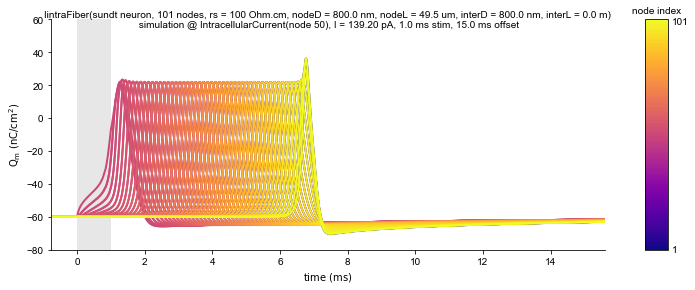

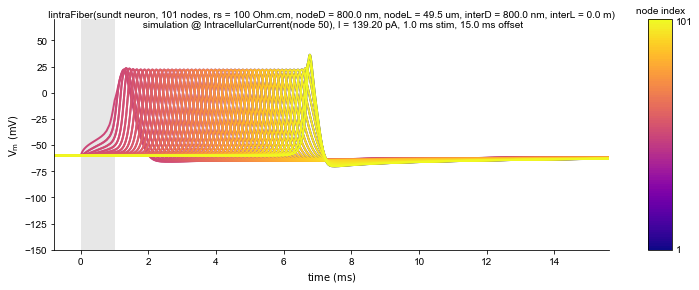

In [9]:
fig1 = SectionCompTimeSeries([(data, meta)], 'Qm', fiber.ids).render()
fig2 = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids).render()
print(f'cv = {fiber.getConductionVelocity(data, out="median"):.2f} m/s')
print(f'dV = {fiber.getSpikeAmp(data, out="median"):.2f} m/s')

As we can see, the behavior of the unmyelinated C-fiber model is in good correspondence with the reference literature (Sundt 2015):
- conduction velocity is slightly slower than reported in the paper (0.54 m/s for the peripheral axon) but agrees with ModelDB simulation results
- action potential waveform (ca. 1-2 ms duration, ca. 87 mV amplitude) seems in line with the paper results
- the excitation threshold (0.12 nA) is in line with the just supra-threshold range of 0.2 nA used in the paper to stimulate the peripheral axon

## Strength-duration curve
Let's compute the threshold injected current required to excite the fiber, for various stimulus durations:

In [12]:
fiber.reset()
durations = np.logspace(-5, -1, 10)  # s
logger.setLevel(logging.WARNING)
Ithrs = np.array([fiber.titrate(psource, PulsedProtocol(x, toffset)) for x in durations])
logger.setLevel(logging.INFO)

 25/11/2019 16:08:18: titration does not converge within this interval
 25/11/2019 16:08:24: titration does not converge within this interval


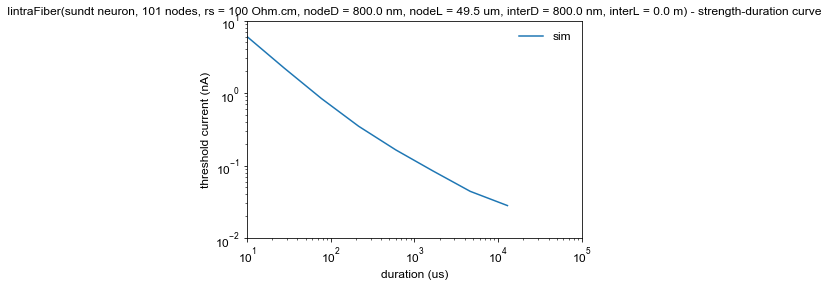

In [13]:
fig = strengthDurationCurve(
    fiber, durations, {'sim': np.array(Ithrs)}, scale='log', plot_chr=False,
    yname='current', yfactor=1e9, yunit='A')

Expectedly, the threshold current required to excite the fiber falls as the stimulus duration increases.

## Conclusions
- The unmyelinated neuron fiber model is implemented
- A maximal node length of about **50 ${\mu}m$** is required to achieve accurate simulations (allowing for a 5% relative error in output metrics)
- Resulting conduction velocity is more than 10 times less than for myelinated fiber
- The strength-duration curve obtained from the simulation data makes empirical sense

## References

- Sundt D, Gamper N, Jaffe DB., *Spike propagation through the dorsal root ganglia in an unmyelinated sensory neuron: a modeling study*, J Neurophysiol 114: 3140–3153, 2015.